## Import required Python modules

## Download data and pre-proces data

In [18]:
import numpy as np
from matplotlib import pyplot as plt
import os
from scipy import stats

In [2]:
# Numpy files 
data_path='Extracted_data'
data_file = 'Train_data.npz'
label_file = 'Train_labels.npy'
data = np.load(os.path.join(data_path,data_file))


In [3]:
X = np.float32(np.dstack((np.float32(data['arr_0']), np.float32(data['arr_1']), np.float32(data['arr_2']),
                          np.float32(data['arr_3']), np.float32(data['arr_4']), np.float32(data['arr_5']),
                         np.float32(data['arr_6']), np.float32(data['arr_7']), np.float32(data['arr_8']),
                         np.float32(data['arr_19']))))
Y = np.int8(np.load(os.path.join(data_path,label_file)) - 1)
Y = np.expand_dims(Y, axis=2)
print(X.shape)
print(Y.shape)

(16310, 6000, 10)
(16310, 6000)


In [4]:
print(X.nbytes)
print(Y.nbytes)

3914400000
97860000


In [5]:
def strided_app(a, L, S ):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.shape[0]-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L,a.shape[1] ), strides=(S*n,n,a.strides[1]))

In [6]:
X2 = []
window = 500
stride = 250
n_sensors = X.shape[2] #Number of sensors
for i in range (0, X.shape[0]):
    X2.append(strided_app(X[i],window,stride))
    
X2 = np.asarray(X2)
X2 = X2.reshape((-1,window,n_sensors))
del X
print(X2.shape)

(375130, 500, 10)


In [26]:
Y2 = []
n_sensors = 1 #Number of sensors
for i in range (0, Y.shape[0]):
    Y2.append(strided_app(Y[i],window,stride))
    
Y2 = np.asarray(Y2)
Y2 = Y2.reshape((-1,window,n_sensors))
Y2 = np.squeeze(Y2)
del Y
Y3 = stats.mode(Y2, axis=1)[0]
Y3 = np.squeeze(Y3)

print(Y2.shape)
print(Y3.shape)

(375130, 500)
(375130,)


## Load the pre-processed data

In [71]:
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, CuDNNLSTM, Dense, Dropout, Flatten, Bidirectional
from keras.layers import Input, Concatenate, TimeDistributed
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Permute, Reshape, Flatten
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [29]:
z = int(0.7 * Y3.shape[0])
z1 = int(0.8 * Y3.shape[0])
X_train0 = X2[:z]
X_val0 = X2[z:z1]
X_test0 = X2[z1:]
y_train = Y3[:z]
y_val = Y3[z:z1]
y_test = Y3[z1:]
print(np.shape(X_train0))
print(np.shape(X_val0))
print(np.shape(X_test0))
print(np.shape(y_train))
print(np.shape(y_val))
print(np.shape(y_test))

(262591, 500, 10)
(37513, 500, 10)
(75026, 500, 10)
(262591,)
(37513,)
(75026,)


In [30]:
np.random.seed(0)
p = np.random.permutation(y_train.shape[0])
y_train = y_train[p]
X_train0 = X_train0[p,:,:]
print(X_train0.shape)
print(y_train.shape)

(262591, 500, 10)
(262591,)


In [31]:
num_classes = 8
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## My Models

In [32]:
def _data_reshaping(X_tr, X_va, X_ts, network_type):
    _, win_len, dim = X_tr.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':
        
        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_tr = np.swapaxes(X_tr,1,2)
        X_va = np.swapaxes(X_va,1,2)
        X_ts = np.swapaxes(X_ts,1,2)

        X_tr = np.reshape(X_tr, (-1, dim, win_len, 1))
        X_va = np.reshape(X_va, (-1, dim, win_len, 1))
        X_ts = np.reshape(X_ts, (-1, dim, win_len, 1))
        
    if network_type=='MLP':
        print('MLP...')
        X_tr = np.reshape(X_tr, (-1, dim*win_len))
        X_va = np.reshape(X_va, (-1, dim*win_len))
        X_ts = np.reshape(X_ts, (-1, dim*win_len))
    
    return X_tr, X_va, X_ts

In [33]:
def model_variant(model, num_feat_map, dim, network_type,p):
    print(network_type)
    if network_type == 'ConvLSTM':
        model.add(Permute((2, 1, 3))) # for swap-dimension
        model.add(Reshape((-1,num_feat_map*dim)))
        model.add(Bidirectional(CuDNNLSTM(32, return_sequences=False, stateful=False)))
        #model.add(LSTM(32, return_sequences=False, stateful=False))
        model.add(Dropout(p))
    if network_type == 'CNN':
        
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(BatchNormalization()) #added
        model.add(Dropout(p))

        
def model_conv(model, num_feat_map,p,b):
    model.add(Conv2D(32, kernel_size=(1, 5),    # Original Kernel size(1,5)
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    if (b==1):
        model.add(BatchNormalization()) #added
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(p))
    model.add(Conv2D(64, kernel_size=(1, 3), activation='relu',padding='same'))  # Original Kernel size(1,5)
    if (b==1):
        model.add(BatchNormalization()) #added
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(p))
    model.add(Conv2D(num_feat_map, kernel_size=(3, 3), activation='relu',padding='same'))  # Original Kernel size(1,5)
    if (b==1):
        model.add(BatchNormalization()) #added
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(p))
    
def model_LSTM(model,p):
    model.add(CuDNNLSTM(num_hidden_lstm, 
               input_shape=(win_len,dim), 
               return_sequences=True))
    model.add(Dropout(p))
    model.add(CuDNNLSTM(num_hidden_lstm, return_sequences=False))
    model.add(Dropout(p))

def model_MLP(model, num_hidden_mlp,p):
    model.add(Dense(num_hidden_mlp, activation='relu', input_shape=(dim*win_len,)))
    model.add(Dropout(p))
    model.add(Dense(num_hidden_mlp, activation='relu'))
    model.add(Dropout(p))
    
def model_output(model):
    model.add(Dense(num_classes, activation='softmax'))

In [34]:
def model_dcbl(p):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(1, 5),    # Original Kernel size(1,5)
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same', name = 'Conv_1'))
    model.add(BatchNormalization(name = 'batch_1')) #added
    model.add(Dropout(p, name = 'drop_1'))
    model.add(Conv2D(128, kernel_size=(1, 5), activation='relu',padding='same', name = 'Conv_2'))  
    model.add(MaxPooling2D(pool_size=(1, 2), name = 'max_1'))
    model.add(BatchNormalization(name = 'batch_2')) #added
    model.add(Dropout(p, name = 'drop_2'))
    model.add(Conv2D(256, kernel_size=(1, 3), activation='relu',padding='same', name = 'Conv_3'))
    model.add(MaxPooling2D(pool_size=(1, 2), name = 'max_2'))
    model.add(BatchNormalization(name = 'batch_3')) #added
    model.add(Dropout(p, name = 'drop_3'))
    model.add(Conv2D(512, kernel_size=(1, 3), activation='relu',padding='same', name = 'Conv_4')) 
    model.add(MaxPooling2D(pool_size=(1, 2), name = 'max_3'))
    model.add(BatchNormalization(name = 'batch_4')) #added
    model.add(Dropout(p, name = 'drop_4'))
    model.add(Conv2D(256, kernel_size=(1, 3), activation='relu',padding='same', name = 'Conv_5')) 
    model.add(BatchNormalization(name = 'batch_5')) #added
    model.add(Dropout(p, name = 'drop_5'))
    model.add(Conv2D(128, kernel_size=(1, 3), activation='relu',padding='same', name = 'Conv_6'))  
    model.add(BatchNormalization(name = 'batch_6')) #added
    model.add(Dropout(p, name = 'drop_6'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same', name = 'Conv_7')) 
    model.add(BatchNormalization(name = 'batch_7')) #added
    model.add(Dropout(p, name = 'drop_7'))
    model.add(Permute((2, 1, 3), name = 'per_1')) # for swap-dimension
    model.add(Reshape((-1,64*dim), name = 'ren_1'))
    model.add(Bidirectional(CuDNNLSTM(32, return_sequences=False, stateful=False, name = 'blstm_1')))
    model.add(BatchNormalization(name = 'batch_8'))
    model.add(Dropout(p, name = 'drop_8'))
    model.add(Dense(256, activation='relu', name = 'dense_1'))
    model.add(BatchNormalization(name = 'batch_9'))
    model.add(Dense(num_classes, activation='softmax', name = 'output'))
    return model

In [86]:
def MA_CNN(input_shape, p=0.3):
    input_acc = Input(name='the_input', shape=input_shape, dtype='float32')
    input_gyr = Input(name='the_input', shape=input_shape, dtype='float32')
    input_mag = Input(name='the_input', shape=input_shape, dtype='float32')
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape,
               padding='same', name='Conv_1')(input_data)
    x = MaxPooling2D(pool_size=(2, 2), name='Max_pool_1')(x)
    x = BatchNormalization(name='Bn_1')(x)
    x = Dropout(p, name='Drop_1')(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='Conv_2')(x)
    x = BatchNormalization(name='Bn_2')(x)
    x = Dropout(p, name='Drop_2')(x)
    x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='Conv_3')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='Max_pool_3')(x)
    x = BatchNormalization(name='Bn_3')(x)
    x = Dropout(p, name='Drop_3')(x),
    x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='Conv_4')(x)
    x = BatchNormalization(name='Bn_4')(x)
    x = Dropout(p, name='Drop_4')(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='Conv_5')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='Max_pool_5')(x)
    x = BatchNormalization(name='Bn_5')(x)
    x = Dropout(p, name='Drop_5')(x)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', name='Conv_6')(x)
    x = BatchNormalization(name='Bn_6')(x)
    x = Dropout(p, name='Drop_6')(x)
    x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', name='Conv_7')(x)
    x = BatchNormalization(name='Bn_7')(x)
    x = Dropout(p, name='Drop_7')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', name='dense_1')(x)
    x = BatchNormalization(name='Bn_8')(x)
    x = Dropout(p, name='Drop_8')(x)
    #output
    d1 = Dense(num_classes, activation='softmax', name='dense_out_1')(x)
    d2 = Dense(num_classes, activation='softmax', name='dense_out_2' )(x)
    d3 = Dense(num_classes, activation='softmax', name='dense_out_3')(x)
    d4 = Dense(num_classes, activation='softmax', name='dense_out_4')(x)
    d5 = Dense(num_classes, activation='softmax', name='dense_out_5')(x)
    d6 = Dense(num_classes, activation='softmax', name='dense_out_6')(x)
    model = Model(input_data, [d1,d2,d3,d4,d5,d6])
    return model

def encoder(s,input_shape, p=0.5):
    input_data = Input(name='input_{}'.format(s), shape=input_shape, dtype='float32')
    x = Conv2D(64, kernel_size=(1, 5), activation='relu', input_shape=input_shape,
               padding='same', name='Conv_1_{}'.format(s))(input_data)
    #x = MaxPooling2D(pool_size=(2, 2), name='Max_pool_1{}'.format(s))(x)
    x = BatchNormalization(name='Bn_1_{}'.format(s))(x)
    x = Dropout(p, name='Drop_1_{}'.format(s))(x)
    x = Conv2D(128, kernel_size=(1, 3), activation='relu', padding='same', name='Conv_2_{}'.format(s))(x)
    x = MaxPooling2D(pool_size=(1, 2), name='Max_pool_2{}'.format(s))(x)
    x = BatchNormalization(name='Bn_2_{}'.format(s))(x)
    x = Dropout(p, name='Drop_2_{}'.format(s))(x)
    x = Conv2D(256, kernel_size=(1, 3), activation='relu', padding='same', name='Conv_3_{}'.format(s))(x)
    #x = MaxPooling2D(pool_size=(2, 2), name='Max_pool_3_{}'.format(s))(x)
    x = BatchNormalization(name='Bn_3_{}'.format(s))(x)
    x = Dropout(p, name='Drop_3_{}'.format(s))(x)
    x = Conv2D(256, kernel_size=(1, 3), activation='relu', padding='same', name='Conv_4_{}'.format(s))(x)
    x = BatchNormalization(name='Bn_4_{}'.format(s))(x)
    x = Dropout(p, name='Drop_4_{}'.format(s))(x)
    x = Conv2D(128, kernel_size=(1, 3), activation='relu', padding='same', name='Conv_5_{}'.format(s))(x)
    x = MaxPooling2D(pool_size=(1, 2), name='Max_pool_5_{}'.format(s))(x)
    x = BatchNormalization(name='Bn_5_{}'.format(s))(x)
    x = Dropout(p, name='Drop_5_{}'.format(s))(x)
    x = Conv2D(64, kernel_size=(1, 3), activation='relu', padding='same', name='Conv_6_{}'.format(s))(x)
    x = BatchNormalization(name='Bn_6'.format(s))(x)
    x = Dropout(p, name='Drop_6_{}'.format(s))(x)
    x = Conv2D(32, kernel_size=(1, 3), activation='relu', padding='same', name='Conv_7_{}'.format(s))(x)
    x = BatchNormalization(name='Bn_7_{}'.format(s))(x)
    x = Dropout(p, name='Drop_7_{}'.format(s))(x)
#     x = Flatten()(x)
#     x = Dense(128, activation='relu', name='dense_1_{}'.format(s))(x)
#     x = BatchNormalization(name='Bn_8_{}'.format(s))(x)
#     x = Dropout(p, name='Drop_8_{}'.format(s))(x)
    model = Model(inputs=input_data, outputs=x, name='Encoder_{}'.format(s))
    return model

def merger(input_shape, encoder_acc, encoder_gyr, encoder_mag, p=0.5):
    input_acc = Input(name='encoded_acc', shape=input_shape, dtype='float32')
    input_gyr = Input(name='encoded_gyr', shape=input_shape, dtype='float32')
    input_mag = Input(name='encoded_mag', shape=input_shape, dtype='float32')
    encode_acc = encoder_acc(input_acc)
    encode_gyr = encoder_gyr(input_gyr)
    encode_mag = encoder_mag(input_mag)
    merged = Concatenate()([encode_acc,  encode_gyr, encode_mag])
    merged = Conv2D(128, kernel_size=(1, 3), activation='relu', padding='same', name='Conv_merged')(merged)
    out = Permute((2, 1, 3), name = 'per_1')(merged) 
    out = Reshape((-1,128*3), name = 'ren_1')(out)
    out = TimeDistributed(Dense(64, name='dense_IR'), name='Time_dense')(out)
    out = BatchNormalization(name = 'batch_7')(out)
    out = Bidirectional(CuDNNLSTM(32, return_sequences=False, stateful=False, name = 'blstm_1'))(out)
    out = BatchNormalization(name = 'batch_8')(out)
    out = Dropout(p, name = 'drop_8')(out)
   # out = Flatten()(out)
    out = Dense(128, activation='relu', name = 'dense_1')(out)
    out = BatchNormalization(name = 'batch_9')(out)
    out = Dense(num_classes, activation='softmax', name = 'output')(out)
    model = Model(inputs=[input_acc,input_gyr,input_mag], outputs=out, name='Merged')
    return model
    

In [36]:
batch_size = 512
num_feat_map = 128
num_hidden_mlp = 128
num_hidden_lstm = 64
num_classes = 8
p=0.3 #Dropout
b = 1 #BatchNorm

#network_type = 'CNN'
network_type = 'ConvLSTM'
#network_type = 'LSTM'
#network_type = 'MLP'
_, win_len, dim = X_train0.shape
print(win_len)
print(dim)

X_train, X_val, X_test = _data_reshaping(X_train0, X_val0, X_test0, network_type)

500
10
ConvLSTM


In [87]:
input_shape = (3, win_len, 1)
encoder_acc = encoder('acc',input_shape)
encoder_gyr = encoder('gyr',input_shape)
encoder_mag = encoder('mag',input_shape)
print(encoder_acc.summary())
print(encoder_gyr.summary())
print(encoder_mag.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_acc (InputLayer)       (None, 3, 500, 1)         0         
_________________________________________________________________
Conv_1_acc (Conv2D)          (None, 3, 500, 64)        384       
_________________________________________________________________
Bn_1_acc (BatchNormalization (None, 3, 500, 64)        256       
_________________________________________________________________
Drop_1_acc (Dropout)         (None, 3, 500, 64)        0         
_________________________________________________________________
Conv_2_acc (Conv2D)          (None, 3, 500, 128)       24704     
_________________________________________________________________
Max_pool_2acc (MaxPooling2D) (None, 3, 250, 128)       0         
_________________________________________________________________
Bn_2_acc (BatchNormalization (None, 3, 250, 128)       512       
__________

In [88]:
merged_model = merger(input_shape, encoder_acc, encoder_gyr, encoder_mag)
print(merged_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoded_acc (InputLayer)        (None, 3, 500, 1)    0                                            
__________________________________________________________________________________________________
encoded_gyr (InputLayer)        (None, 3, 500, 1)    0                                            
__________________________________________________________________________________________________
encoded_mag (InputLayer)        (None, 3, 500, 1)    0                                            
__________________________________________________________________________________________________
Encoder_acc (Model)             (None, 3, 125, 32)   453472      encoded_acc[0][0]                
__________________________________________________________________________________________________
Encoder_gy

In [89]:
epochs = 150
batch_size = 200

merged_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# checkpoint
filepath="weights_best_merged.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

H = merged_model.fit([X_train[:,0:3], X_train[:,3:6], X_train[:,6:9]], y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=([X_val[:,0:3], X_val[:,3:6], X_val[:,6:9]], y_val),
             callbacks=callbacks_list)

Train on 262591 samples, validate on 37513 samples
Epoch 1/150
262591/262591 [==============================] - 877s 3ms/step - loss: 0.6907 - acc: 0.7517 - val_loss: 2.4276 - val_acc: 0.4284

Epoch 00001: val_acc improved from -inf to 0.42844, saving model to weights_best_merged.hdf5
Epoch 2/150
262591/262591 [==============================] - 862s 3ms/step - loss: 0.4175 - acc: 0.8592 - val_loss: 2.2057 - val_acc: 0.4740

Epoch 00002: val_acc improved from 0.42844 to 0.47405, saving model to weights_best_merged.hdf5
Epoch 3/150
262591/262591 [==============================] - 855s 3ms/step - loss: 0.3388 - acc: 0.8879 - val_loss: 1.5411 - val_acc: 0.5588

Epoch 00003: val_acc improved from 0.47405 to 0.55882, saving model to weights_best_merged.hdf5
Epoch 4/150
262591/262591 [==============================] - 855s 3ms/step - loss: 0.2836 - acc: 0.9074 - val_loss: 1.2365 - val_acc: 0.6075

Epoch 00004: val_acc improved from 0.55882 to 0.60747, saving model to weights_best_merged.hdf5


262591/262591 [==============================] - 858s 3ms/step - loss: 0.0684 - acc: 0.9788 - val_loss: 2.0807 - val_acc: 0.6342

Epoch 00041: val_acc did not improve from 0.71189
Epoch 42/150
262591/262591 [==============================] - 857s 3ms/step - loss: 0.0686 - acc: 0.9786 - val_loss: 2.0004 - val_acc: 0.6409

Epoch 00042: val_acc did not improve from 0.71189
Epoch 43/150
262591/262591 [==============================] - 857s 3ms/step - loss: 0.0666 - acc: 0.9792 - val_loss: 2.0201 - val_acc: 0.6386

Epoch 00043: val_acc did not improve from 0.71189
Epoch 44/150
262591/262591 [==============================] - 857s 3ms/step - loss: 0.0661 - acc: 0.9795 - val_loss: 2.1732 - val_acc: 0.6262

Epoch 00044: val_acc did not improve from 0.71189
Epoch 45/150
262591/262591 [==============================] - 858s 3ms/step - loss: 0.0646 - acc: 0.9800 - val_loss: 1.7782 - val_acc: 0.6684

Epoch 00045: val_acc did not improve from 0.71189
Epoch 46/150
262591/262591 [====================

KeyboardInterrupt: 

In [76]:
X_train.shape

(262591, 10, 500, 1)

In [42]:
p=0.4
model = model_dcbl(p)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 11, 600, 64)       384       
_________________________________________________________________
batch_1 (BatchNormalization) (None, 11, 600, 64)       256       
_________________________________________________________________
drop_1 (Dropout)             (None, 11, 600, 64)       0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 600, 128)      41088     
_________________________________________________________________
max_1 (MaxPooling2D)         (None, 11, 300, 128)      0         
_________________________________________________________________
batch_2 (BatchNormalization) (None, 11, 300, 128)      512       
_________________________________________________________________
drop_2 (Dropout)             (None, 11, 300, 128)      0         
__________

In [16]:

print('building the model ... ')
model = Sequential()

if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map,p,b)
    model_variant(model, num_feat_map, dim, network_type,p)
if network_type=='LSTM':
    model_LSTM(model,p)
if network_type=='MLP': 
    model_MLP(model, num_hidden_mlp,p) 
       
model_output(model)    
model.summary()

building the model ... 
ConvLSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 11, 600, 32)       192       
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 600, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 300, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 300, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 300, 64)       6208      
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 300, 64)       256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 150

In [43]:
epochs = 150
batch_size = 200

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# checkpoint
filepath="weights_best_mag.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

H = model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=(X_val, y_val),
             callbacks=callbacks_list)

Train on 216923 samples, validate on 30989 samples
Epoch 1/150
216923/216923 [==============================] - 945s 4ms/step - loss: 0.9390 - acc: 0.6544 - val_loss: 2.0124 - val_acc: 0.3854

Epoch 00001: val_acc improved from -inf to 0.38536, saving model to weights_best_mag.hdf5
Epoch 2/150
216923/216923 [==============================] - 929s 4ms/step - loss: 0.5711 - acc: 0.8086 - val_loss: 1.1170 - val_acc: 0.6497

Epoch 00002: val_acc improved from 0.38536 to 0.64971, saving model to weights_best_mag.hdf5
Epoch 3/150
216923/216923 [==============================] - 926s 4ms/step - loss: 0.4573 - acc: 0.8528 - val_loss: 1.0700 - val_acc: 0.6858

Epoch 00003: val_acc improved from 0.64971 to 0.68582, saving model to weights_best_mag.hdf5
Epoch 4/150
216923/216923 [==============================] - 925s 4ms/step - loss: 0.3895 - acc: 0.8771 - val_loss: 0.9710 - val_acc: 0.7221

Epoch 00004: val_acc improved from 0.68582 to 0.72213, saving model to weights_best_mag.hdf5
Epoch 5/150


216923/216923 [==============================] - 929s 4ms/step - loss: 0.0954 - acc: 0.9702 - val_loss: 1.6289 - val_acc: 0.6837

Epoch 00041: val_acc did not improve from 0.74836
Epoch 42/150
216923/216923 [==============================] - 928s 4ms/step - loss: 0.0952 - acc: 0.9699 - val_loss: 1.3732 - val_acc: 0.7191

Epoch 00042: val_acc did not improve from 0.74836
Epoch 43/150
216923/216923 [==============================] - 928s 4ms/step - loss: 0.0937 - acc: 0.9700 - val_loss: 1.5156 - val_acc: 0.7157

Epoch 00043: val_acc did not improve from 0.74836
Epoch 44/150
216923/216923 [==============================] - 929s 4ms/step - loss: 0.0925 - acc: 0.9706 - val_loss: 1.4955 - val_acc: 0.7136

Epoch 00044: val_acc did not improve from 0.74836
Epoch 45/150
216923/216923 [==============================] - 928s 4ms/step - loss: 0.0889 - acc: 0.9713 - val_loss: 1.5992 - val_acc: 0.7082

Epoch 00045: val_acc did not improve from 0.74836
Epoch 46/150
216923/216923 [====================

KeyboardInterrupt: 

In [94]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import itertools

In [93]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [103]:
#model = load_model('weights_best_mag.hdf5')
model = load_model('weights_best_merged.hdf5')

In [96]:
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [106]:
y_pred = np.argmax(model.predict([X_test[:,0:3], X_test[:,3:6], X_test[:,6:9]]), axis=1)
y_true = np.argmax(y_test, axis=1)
#y_true = y_test
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
accuracy = accuracy_score(y_true, y_pred)


print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.2f}'.format(accuracy))

[[6979  634    2   87   56   83 1689  473]
 [ 133 7921    6   20    1    9    6   31]
 [   1   60 6262    3    0    0    0    0]
 [ 246  167    3 7904   74   46   24    5]
 [   3    0    0    2  585   78   25    2]
 [ 462   84    0  175  532 6195 1068  815]
 [2769  188    0    5 1178  996 8649 3777]
 [1804  291    1   71  421 1399 5435 5091]]
the mean-f1 score: 0.67
accuracy is: 0.66


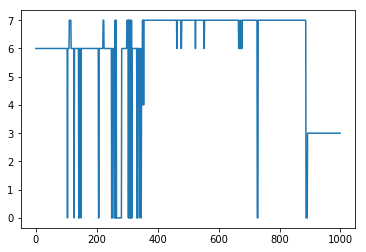

In [107]:
plt.figure()
plt.plot(y_pred[:1000])
#plt.plot(y_true[:100])
plt.show()

In [108]:
(int(len(y_pred)/23)+1)

3263

In [109]:
k = 23
y_pred2 = np.zeros((int(len(y_pred)/k)+1))
y_true2 = np.zeros((int(len(y_pred)/k)+1))
ind = 0
for i in range (0,len(y_pred), k):
    (values,counts) = np.unique(y_pred[i:i+k],return_counts=True)
    c = np.argmax(counts)
    y_pred2[ind] = values[c]
    (values,counts) = np.unique(y_true[i:i+k],return_counts=True)
    c = np.argmax(counts)
    y_true2[ind] = values[c]
    ind = ind+1

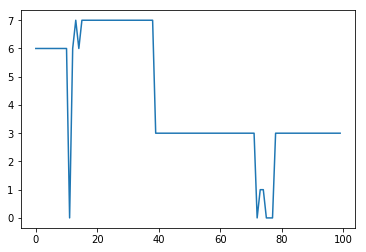

In [110]:
plt.figure()
plt.plot(y_pred2[:100])
#plt.plot(y_true[:100])
plt.show()

In [111]:
cf_matrix = confusion_matrix(y_true2, y_pred2)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true2, y_pred2, average=None)*100)*0.01
accuracy = accuracy_score(y_true2, y_pred2)

print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.2f}'.format(accuracy))

[[317  27   0   0   0   1  70  21]
 [  2 350   0   0   0   0   0   1]
 [  0   1 275   0   0   0   0   0]
 [  8   2   0 359   1   0   0   0]
 [  0   0   0   0  27   3   0   0]
 [ 12   4   0   5  19 297  45  24]
 [127   3   0   0  48  36 399 152]
 [ 74  10   0   1  10  52 249 231]]
the mean-f1 score: 0.71
accuracy is: 0.69


In [22]:
print(y_pred2.shape)
y_pred2 = np.int8(y_pred2) + 1
y_pred2 = y_pred2.repeat(6000).reshape(-1,6000)
print(y_pred2.shape)

# y_true = np.int8(data['arr_20'] )
# y_true = y_true[-2397:,:] #test = -2397:, val = 1739
# #y_true = y_true[:1739,:]
# print(y_true.shape)

out_path='/home/sandeep/storage/HASCA-Workshop/Vikranth/Predictions/Final_60/'

# data file with all the 16310 frames: 'Data_16310.npz'
# data file with only 1000 frames: 'Data_1000.npz'

out_file='shl_all_92'
np.save(out_path + out_file, y_pred2)

(5698,)
(5698, 6000)


In [25]:
# #y_true = y_true.reshape(-1)
# y_pred2 = y_pred2.reshape(-1)
# #print(y_true.shape)
# print(y_pred2.shape)
# cf_matrix = confusion_matrix(y_true, y_pred2)
# print(cf_matrix)
# class_wise_f1 = f1_score(y_true, y_pred2, average=None)
# accuracy = accuracy_score(y_true, y_pred2)

# print('the mean-f1 score: {:.6f}'.format(np.mean(class_wise_f1)))
# print('accuracy is: {:.6f}'.format(accuracy))

(14382000,)
(14382000,)
[[2030415   17765    2528    6626   25409    8586   41325    4904]
 [  31460 1745173    1555    7421    1076    1361    9704    8796]
 [      0    4898  584178       0    1324       0       0       0]
 [  37083   17419    2538 1818924     851    1531    3411       0]
 [  12000    4019    1037    3971 2190592    6000   24000       0]
 [   9390    7878    2164    2710   12748 1709835   19057       0]
 [ 117762    2383       0    2348       0   12687 1926870   52273]
 [ 107890    6465       0       0    6000       0  381633 1344027]]
the mean-f1 score: 0.933424
accuracy is: 0.928245


In [25]:
y_pred2 = np.zeros((int(len(y_pred)/10)*2))
#y_true2 = np.zeros((int(len(y_pred)/10)*2))
ind = 0
for i in range (0,len(y_pred), 10):
    (values,counts) = np.unique(y_pred[i:i+5],return_counts=True)
    c = np.argmax(counts)
    y_pred2[ind] = values[c]
#     (values,counts) = np.unique(y_true[i:i+5],return_counts=True)
#     c = np.argmax(counts) 
#     y_true2[ind] = values[c]
    (values,counts) = np.unique(y_pred[i+5:i+10],return_counts=True)
    c = np.argmax(counts)
    y_pred2[ind+1] = values[c]
#     (values,counts) = np.unique(y_true[i+5:i+10],return_counts=True)
#     c = np.argmax(counts)
#     y_true2[ind+1] = values[c]
    ind = ind+2

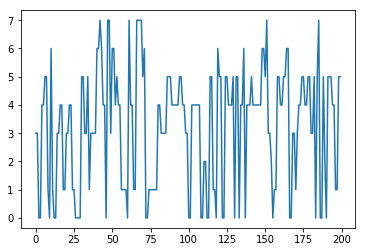

In [27]:
plt.figure()
plt.plot(y_pred2[:200])
#plt.plot(y_true[:100])
plt.show()

In [28]:
print(y_pred2.shape)
y_pred2 = np.int8(y_pred2) + 1
y_pred2 = y_pred2.repeat(3000).reshape(-1,6000)
print(y_pred2.shape)

# y_true = np.int8(data['arr_20'] )
# y_true = y_true[-2397:,:] #test = -2397:, val = 1739
# #y_true = y_true[:1739,:]
# print(y_true.shape)

out_path='/home/sandeep/storage/HASCA-Workshop/Vikranth/Predictions/Final_30/'

# data file with all the 16310 frames: 'Data_16310.npz'
# data file with only 1000 frames: 'Data_1000.npz'

out_file='shl_all_92'
np.save(out_path + out_file, y_pred2)

(11396,)
(5698, 6000)


In [29]:
y_true = y_true.reshape(-1)
y_pred2 = y_pred2.reshape(-1)
print(y_true.shape)
print(y_pred2.shape)
cf_matrix = confusion_matrix(y_true, y_pred2)
print(cf_matrix)
class_wise_f1 = f1_score(y_true, y_pred2, average=None)
accuracy = accuracy_score(y_true, y_pred2)

print('the mean-f1 score: {:.6f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.6f}'.format(accuracy))

(14382000,)
(14382000,)
[[2033822   14496       0    5020   19727   11961   45335    7197]
 [  38138 1739489    4559    3138    1540    9202    6209    4271]
 [    472    7902  580728     462       0     836       0       0]
 [  33508    4136       0 1834772    1187    4531     623    3000]
 [  18000    3074    2713    1307 2189525    6000   18000    3000]
 [  19484    4057       0    2710   21748 1700783   15000       0]
 [ 108509    2615       0    3591    7273   24687 1895648   72000]
 [ 142067    6231       0    3000    6000   42000  371185 1275532]]
the mean-f1 score: 0.926050
accuracy is: 0.921311


In [28]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

accuracy is: 0.41


In [20]:
model.save('Conv_lstm_mag')